이 커널은 https://www.kaggle.com/janged/3rd-ml-month-car-model-classification-xception 을 필사하면서 공부한 커널입니다.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'train.csv', 'sample_submission.csv', 'class.csv', 'test', 'test.csv']


In [2]:
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

warnings.filterwarnings('ignore')

image_size = 299           # Xception model에 적합한 이미지 사이즈는 299 * 299
application = Xception
batch_size = 32

Using TensorFlow backend.


In [3]:
DATA_PATH = '../input'
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [4]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [5]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


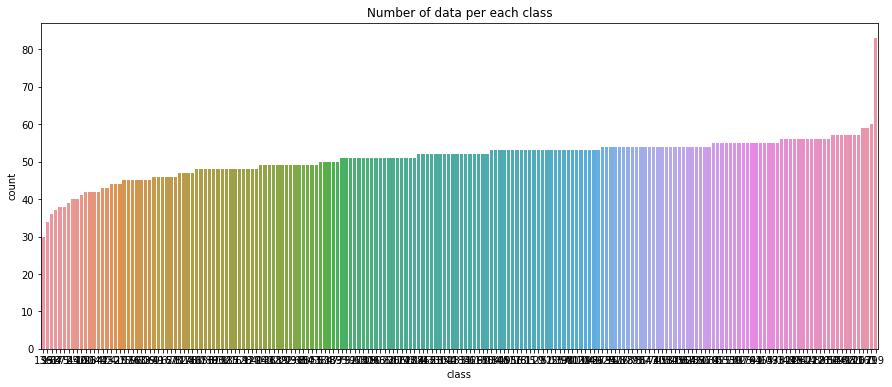

In [6]:
plt.figure(figsize=(15, 6))
sns.countplot(df_train['class'], order=df_train['class'].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

In [7]:
df_train['class'].value_counts()

119    83
79     60
161    59
167    59
20     57
171    57
98     57
182    57
191    57
144    57
56     57
65     56
81     56
82     56
112    56
72     56
114    56
162    56
194    56
115    56
24     56
148    56
8      56
73     55
43     55
109    55
165    55
1      55
44     55
6      55
       ..
62     46
116    46
49     46
69     46
39     45
12     45
60     45
163    45
150    45
159    45
157    45
27     44
41     44
152    44
42     43
47     43
141    42
134    42
26     42
100    42
10     41
142    40
45     40
2      39
71     38
175    38
64     37
158    36
99     34
136    30
Name: class, Length: 196, dtype: int64

In [8]:
df_train['class'].value_counts().describe()

count    196.000000
mean      50.969388
std        5.374115
min       30.000000
25%       48.000000
50%       52.000000
75%       54.000000
max       83.000000
Name: class, dtype: float64

In [9]:
def crop_boxing_img(img_name, margin=16, size=(image_size, image_size)):
    if img_name.split('_')[0] == 'train':
        PATH = TRAIN_IMG_PATH
        data = df_train
    else:
        PATH = TEST_IMG_PATH
        data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1, y1, x2, y2)).resize(size)

잘라낸 사진들을 디렉토리에 각 클래스별로 저장을 합니다. 

저장할 때 훈련 데이터 디렉토리와 검증 디렉토리, 테스트용 디렉터리 분류하여 저장합니다. 훈련용과 검증용 개수는 7:3입니다.

디렉토리에 저장한 이유는 이미지 파일을 PC에서 바로 열어보기 편하기 때문입니다.

In [10]:
nb_train_sample = df_train.shape[0] * 0.7
nb_validation_sample = df_train.shape[0] - nb_train_sample
nb_test_sample = df_test.shape[0]

In [11]:
TRAIN_CROPPED_PATH = '../cropped_train'
VALID_CROPPED_PATH = '../cropped_valid'
TEST_CROPPED_PATH = '../cropped_test'

훈련 디렉토리 / 검증 디렉토리 / 테스트 디렉토리 생성

In [12]:
if (os.path.isdir(TRAIN_CROPPED_PATH) == False):
    os.mkdir(TRAIN_CROPPED_PATH)
    
if (os.path.isdir(VALID_CROPPED_PATH) == False):
    os.mkdir(VALID_CROPPED_PATH)
    
if (os.path.isdir(TEST_CROPPED_PATH) == False):
    os.mkdir(TEST_CROPPED_PATH)

클래스별 디렉토리를 만들기 위해서 class형을 문자열로 변경

In [13]:
df_train['class'] = df_train['class'].astype('str')

In [14]:
for i, row in df_train.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    
    if (i < nb_train_sample):
        class_path = os.path.join(TRAIN_CROPPED_PATH, df_train['class'][i])
        if(os.path.isdir(class_path) == False):
            os.mkdir(class_path)

        cropped.save(os.path.join(class_path, row['img_file']))
    else:
        class_path = os.path.join(VALID_CROPPED_PATH, df_train['class'][i])
        if(os.path.isdir(class_path) == False):
            os.mkdir(class_path)

        cropped.save(os.path.join(class_path, row['img_file']))

for i, row in df_test.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(os.path.join(TEST_CROPPED_PATH, row['img_file']))

keras의 ImageDataGenerator를 이용하여 데이터를 증식합니다.

- rotation_range : 랜덤하게 사진을 회전시킬 각도 범위
- width_shift_range : 사진 수평이동 비율
- height_shift_range : 사진 수직이동 비율
- horizontal_flip : 사진 수평으로 뒤집기
- zoom_range : 랜덤하게 사진 확대
- fill_mode : 사진을 회전 / 이동한 후에 새롭게 생성해야할 픽셀을 채울 방법

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [16]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_CROPPED_PATH,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=1993,
    color_mode='rgb'
)

Found 6993 images belonging to 196 classes.


In [17]:
validation_generator = valid_datagen.flow_from_directory(
    VALID_CROPPED_PATH,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    seed=1993,
    color_mode='rgb'
)

Found 2997 images belonging to 196 classes.


In [18]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROPPED_PATH,
    x_col='img_file',
    y_col=None,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 6150 validated image filenames.


In [19]:
def get_model():
    base_model = Xception(weights='imagenet', input_shape=(299, 299, 3), include_top=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(196, activation='softmax'))
    
    model.summary()
    
    optimizer = optimizers.RMSprop(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    
    return model

In [20]:
model = get_model()

83689472/83683744 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               200900    
Total params: 23,160,556
Trainable params: 23,106,028
Non-trainable params: 54,528
_________________________________________________________________


훈련하면서 검증데이터에 대해서 val_loss가 가장 작은 경우에 대해서 weight 저장.

In [21]:
model_path = '../model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_path = model_path + 'best_model.hdf5'

훈련 중 val_loss가 2회 연속 개선이 되지 않는다면 멈추기 위해서

In [22]:
patient = 2
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience=patient, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patient/2, min_lr=0.00001, verbose=1, mode='min'),
    ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
]

In [23]:
def get_steps(num_samples, batch_size):
    if(num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [25]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=get_steps(nb_train_sample, batch_size),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=get_steps(nb_validation_sample, batch_size),
    verbose=1,
    callbacks = callbacks1
)

Epoch 1/100
219/219 [==============================] - 236s 1s/step - loss: 4.8868 - acc: 0.0515 - val_loss: 3.9317 - val_acc: 0.1832

Epoch 00001: val_loss improved from inf to 3.93166, saving model to ../model/best_model.hdf5
Epoch 2/100
219/219 [==============================] - 218s 997ms/step - loss: 3.3869 - acc: 0.2490 - val_loss: 2.2428 - val_acc: 0.4738

Epoch 00002: val_loss improved from 3.93166 to 2.24277, saving model to ../model/best_model.hdf5
Epoch 3/100
219/219 [==============================] - 219s 998ms/step - loss: 2.0547 - acc: 0.5033 - val_loss: 1.3913 - val_acc: 0.6703

Epoch 00003: val_loss improved from 2.24277 to 1.39135, saving model to ../model/best_model.hdf5
Epoch 4/100
219/219 [==============================] - 219s 999ms/step - loss: 1.2547 - acc: 0.6742 - val_loss: 0.9356 - val_acc: 0.7871

Epoch 00004: val_loss improved from 1.39135 to 0.93559, saving model to ../model/best_model.hdf5
Epoch 5/100
219/219 [==============================] - 219s 1s/step

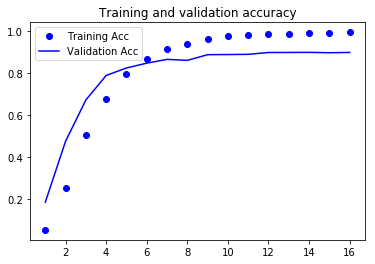

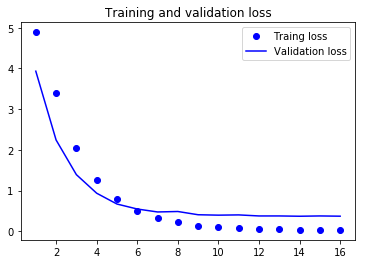

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Traing loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
model.load_weights(model_path)
test_generator.reset()

prediction = model.predict_generator(
    generator=test_generator,
    steps = get_steps(nb_test_sample, batch_size),
    verbose = 1
)

193/193 [==============================] - 34s 177ms/step


In [29]:
predicted_class_indices = np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission['class'] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18
